# The Feature Engineering notebook

- The y-set for location A, B and C are concatonated (time index)
- The X-set for location A, B and C are concatonated (time index)
- One hot encoding for location and whether or not set is from the estimated column
- The y-set and the X-set are merged on date and location
- Having date features

Some added featrues:
- is_weekend
- season
- sun_above_threshold
- cos_sun_azimuth 
- sin_sun_azimuth 
- interaction_clear_sky_rad_sun_elevation
- interaction_clear_sky_rad_effective_cloud_cover

In [256]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import xgboost as xgb
import math
import csv
import seaborn as sns
plt.style.use('fivethirtyeight')
%matplotlib inline

In [257]:
import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score

## for Deep-learing:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
#from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.utils import to_categorical
#from keras.layers.convolutional import Conv1D
from keras.layers import Dropout

In [258]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

X_train_estimated_a = pd.read_parquet('../A/X_train_estimated.parquet')
X_train_estimated_b = pd.read_parquet('../B/X_train_estimated.parquet')
X_train_estimated_c = pd.read_parquet('../C/X_train_estimated.parquet')

X_train_observed_a = pd.read_parquet('../A/X_train_observed.parquet')
X_train_observed_b = pd.read_parquet('../B/X_train_observed.parquet')
X_train_observed_c = pd.read_parquet('../C/X_train_observed.parquet')

X_test_estimated_a = pd.read_parquet('../A/X_test_estimated.parquet')
X_test_estimated_b = pd.read_parquet('../B/X_test_estimated.parquet')
X_test_estimated_c = pd.read_parquet('../C/X_test_estimated.parquet')

## Handling the Y-set

In [259]:
train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

Normalizing values

In [260]:
from sklearn.preprocessing import MinMaxScaler

scaler_a = MinMaxScaler()
scaler_b = MinMaxScaler()
scaler_c = MinMaxScaler()

In [261]:
train_a['pv_measurement'] = scaler_a.fit_transform(train_a[['pv_measurement']])
train_b['pv_measurement'] = scaler_b.fit_transform(train_b[['pv_measurement']])
train_c['pv_measurement'] = scaler_c.fit_transform(train_c[['pv_measurement']])

In [262]:
train_a['location'] = 'A'
train_b['location'] = 'B'
train_c['location'] = 'C'

In [263]:
y = pd.concat([train_a, train_b, train_c])
y.index.name = 'time'
y = pd.get_dummies(y, prefix='location', columns=['location'])
encoded_columns = [col for col in y.columns if 'location_' in col]
y[encoded_columns] = y[encoded_columns].astype(int)

y.shape
y.head()

,pv_measurement,location_A,location_B,location_C
time,,,,
2019-06-02 22:00:00,0.000000,1,0,0
2019-06-02 23:00:00,0.000000,1,0,0
2019-06-03 00:00:00,0.000000,1,0,0
2019-06-03 01:00:00,0.000000,1,0,0
2019-06-03 02:00:00,0.003377,1,0,0


Setting the index to **date_forecast** and resampling with mean.

In [264]:

X_train_observed_a['date_forecast'] = pd.to_datetime(X_train_observed_a['date_forecast'])
X_train_observed_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_observed_a.drop("date_calc", axis=1, inplace=True)
X_train_observed_a = X_train_observed_a.resample('60min').mean()


X_train_estimated_a['date_forecast'] = pd.to_datetime(X_train_estimated_a['date_forecast'])
X_train_estimated_a.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_a:
    X_train_estimated_a.drop("date_calc", axis=1, inplace=True)
X_train_estimated_a = X_train_estimated_a.resample('60min').mean()


X_train_observed_b['date_forecast'] = pd.to_datetime(X_train_observed_b['date_forecast'])
X_train_observed_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_b:
    X_train_observed_b.drop("date_calc", axis=1, inplace=True)
X_train_observed_b = X_train_observed_b.resample('60min').mean()


X_train_estimated_b['date_forecast'] = pd.to_datetime(X_train_estimated_b['date_forecast'])
X_train_estimated_b.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_b:
    X_train_estimated_b.drop("date_calc", axis=1, inplace=True)
X_train_estimated_b = X_train_estimated_b.resample('60min').mean()


X_train_observed_c['date_forecast'] = pd.to_datetime(X_train_observed_c['date_forecast'])
X_train_observed_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_observed_c:
    X_train_observed_c.drop("date_calc", axis=1, inplace=True)
X_train_observed_c = X_train_observed_c.resample('60min').mean()


X_train_estimated_c['date_forecast'] = pd.to_datetime(X_train_estimated_c['date_forecast'])
X_train_estimated_c.set_index('date_forecast', inplace=True)
if "date_calc" in X_train_estimated_c:
    X_train_estimated_c.drop("date_calc", axis=1, inplace=True)
X_train_estimated_c = X_train_estimated_c.resample('60min').mean()


In [265]:
X_train_observed_a['location'], X_train_estimated_a['location'] = 'A', 'A'
X_train_observed_b['location'], X_train_estimated_b['location']= 'B', 'B'
X_train_observed_c['location'], X_train_estimated_c['location']= 'C', 'C'

X_train_observed_a['estimated'], X_train_estimated_a['estimated'] = 0, 1
X_train_observed_b['estimated'], X_train_estimated_b['estimated'] = 0, 1
X_train_observed_c['estimated'], X_train_estimated_c['estimated'] = 0, 1

In [266]:
X = pd.concat([X_train_observed_a, X_train_estimated_a, X_train_observed_b,
               X_train_estimated_b, X_train_observed_c, X_train_estimated_c
               ], ignore_index=False)
X = X.sort_index()

One hot encoding on location

In [267]:
# One hot encoding
X = pd.get_dummies(X, prefix='location', columns=['location'])
encoded_columns = [col for col in X.columns if 'location_' in col]
X[encoded_columns] = X[encoded_columns].astype(int)

In [268]:
df = pd.merge(y, X, left_on=[y.index, 'location_A', 'location_B', 'location_C'],
              right_on=[X.index, 'location_A', 'location_B', 'location_C'])

df.set_index('key_0', inplace=True)
df.index.name = "time"
df = df.sort_index()
pd.set_option('display.max_columns', None)
df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,0.00,275.149994,0.0,0.0,0.0,0.0,81.824997,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.000000,0.0375,0.75,974.099976,980.174988,0.00,0.0,89.099998,986.224976,NaN,0.0,0.0,0.0,0.05,20.724251,-48.319252,0.0,278.250000,86.324997,16827.800781,2.800,1.175,2.550,0.0,0,NaT
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,1.00,274.975006,0.0,0.0,0.0,0.0,78.699997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.949951,0.0450,0.75,972.150024,978.174988,0.20,0.0,89.949997,984.250000,NaN,0.0,0.0,0.0,0.05,20.734001,-48.355999,0.0,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,0,NaT
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,0.75,274.649994,0.0,0.0,0.0,0.0,97.375000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.174988,0.0150,0.25,971.250000,977.299988,0.15,0.0,89.000000,983.375000,NaN,0.0,0.0,0.0,0.10,40.327751,-44.950500,0.0,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,0,NaT
2019-01-01 01:00:00,0.0,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,0.00,274.825012,0.0,0.0,0.0,0.0,97.474998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.150024,0.0125,0.25,973.250000,979.325012,0.00,0.0,88.425003,985.400024,NaN,0.0,0.0,0.0,0.10,40.307251,-44.919750,0.0,278.075012,99.074997,12777.449219,3.550,1.525,3.200,0.0,0,NaT
2019-01-01 02:00:00,0.0,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,0.00,274.799988,0.0,0.0,0.0,0.0,96.425003,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,985.950012,0.0000,0.00,973.049988,979.099976,0.00,0.0,87.300003,985.174988,NaN,0.0,0.0,0.0,0.10,57.805000,-39.863998,0.1,278.049988,97.925003,11140.500000,4.025,2.150,3.425,0.0,0,NaT


In [269]:
def create_features(df):
    """
    Create Features
    """
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    df['is_weekend'] = (df.index.weekday >= 5).astype(int)
    df['season'] = df.index.month.map(get_season)

    # Set a threshold for sun elevation (in degrees)
    elevation_threshold = 10  

    # Binary feature for significant sun elevation
    df['sun_above_threshold'] = (df['sun_elevation:d'] > elevation_threshold).astype(int)

    # Cosine and sine transformations of sun azimuth
    df['cos_sun_azimuth'] = np.cos(np.radians(df['sun_azimuth:d']))
    df['sin_sun_azimuth'] = np.sin(np.radians(df['sun_azimuth:d']))

    df['interaction_clear_sky_rad_sun_elevation'] = df['clear_sky_rad:W'] * df['sun_elevation:d']
    df['interaction_clear_sky_rad_effective_cloud_cover'] = df['clear_sky_rad:W'] * df['effective_cloud_cover:p']

    return df

def get_season(month):
    if 3 <= month <= 5:
        return 0  # spring
    elif 6 <= month <= 8:
        return 1  # summer
    elif 9 <= month <= 11:
        return 2  # fall
    else:
        return 3  # winter

df = create_features(df)

df.head()

,pv_measurement,location_A,location_B,location_C,absolute_humidity_2m:gm3,air_density_2m:kgm3,ceiling_height_agl:m,clear_sky_energy_1h:J,clear_sky_rad:W,cloud_base_agl:m,dew_or_rime:idx,dew_point_2m:K,diffuse_rad:W,diffuse_rad_1h:J,direct_rad:W,direct_rad_1h:J,effective_cloud_cover:p,elevation:m,fresh_snow_12h:cm,fresh_snow_1h:cm,fresh_snow_24h:cm,fresh_snow_3h:cm,fresh_snow_6h:cm,is_day:idx,is_in_shadow:idx,msl_pressure:hPa,precip_5min:mm,precip_type_5min:idx,pressure_100m:hPa,pressure_50m:hPa,prob_rime:p,rain_water:kgm2,relative_humidity_1000hPa:p,sfc_pressure:hPa,snow_density:kgm3,snow_depth:cm,snow_drift:idx,snow_melt_10min:mm,snow_water:kgm2,sun_azimuth:d,sun_elevation:d,super_cooled_liquid_water:kgm2,t_1000hPa:K,total_cloud_cover:p,visibility:m,wind_speed_10m:ms,wind_speed_u_10m:ms,wind_speed_v_10m:ms,wind_speed_w_1000hPa:ms,estimated,date_calc,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,is_weekend,season,sun_above_threshold,cos_sun_azimuth,sin_sun_azimuth,interaction_clear_sky_rad_sun_elevation,interaction_clear_sky_rad_effective_cloud_cover
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:00:00,0.0,0,1,0,5.525,1.23975,1200.675049,0.0,0.0,1200.675049,0.00,275.149994,0.0,0.0,0.0,0.0,81.824997,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,987.000000,0.0375,0.75,974.099976,980.174988,0.00,0.0,89.099998,986.224976,NaN,0.0,0.0,0.0,0.05,20.724251,-48.319252,0.0,278.250000,86.324997,16827.800781,2.800,1.175,2.550,0.0,0,NaT,0,1,1,1,2019,1,1,1,0,3,0,0.935294,0.353871,-0.0,0.0
2019-01-01 00:00:00,NaN,0,0,1,5.475,1.24075,1130.025024,0.0,0.0,1130.025024,1.00,274.975006,0.0,0.0,0.0,0.0,78.699997,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.949951,0.0450,0.75,972.150024,978.174988,0.20,0.0,89.949997,984.250000,NaN,0.0,0.0,0.0,0.05,20.734001,-48.355999,0.0,278.350006,83.824997,16509.250000,2.900,1.125,2.625,0.0,0,NaT,0,1,1,1,2019,1,1,1,0,3,0,0.935234,0.354030,-0.0,0.0
2019-01-01 01:00:00,NaN,0,0,1,5.350,1.24000,1066.674927,0.0,0.0,1066.674927,0.75,274.649994,0.0,0.0,0.0,0.0,97.375000,24.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.174988,0.0150,0.25,971.250000,977.299988,0.15,0.0,89.000000,983.375000,NaN,0.0,0.0,0.0,0.10,40.327751,-44.950500,0.0,278.200012,99.074997,13277.525391,3.650,1.425,3.350,0.0,0,NaT,1,1,1,1,2019,1,1,1,0,3,0,0.762355,0.647159,-0.0,0.0
2019-01-01 01:00:00,0.0,0,1,0,5.425,1.23975,1131.424927,0.0,0.0,1131.424927,0.00,274.825012,0.0,0.0,0.0,0.0,97.474998,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,986.150024,0.0125,0.25,973.250000,979.325012,0.00,0.0,88.425003,985.400024,NaN,0.0,0.0,0.0,0.10,40.307251,-44.919750,0.0,278.075012,99.074997,12777.449219,3.550,1.525,3.200,0.0,0,NaT,1,1,1,1,2019,1,1,1,0,3,0,0.762586,0.646886,-0.0,0.0
2019-01-01 02:00:00,0.0,0,1,0,5.400,1.23850,1061.000000,0.0,0.0,1061.000000,0.00,274.799988,0.0,0.0,0.0,0.0,96.425003,7.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,985.950012,0.0000,0.00,973.049988,979.099976,0.00,0.0,87.300003,985.174988,NaN,0.0,0.0,0.0,0.10,57.805000,-39.863998,0.1,278.049988,97.925003,11140.500000,4.025,2.150,3.425,0.0,0,NaT,2,1,1,1,2019,1,1,1,0,3,0,0.532802,0.846240,-0.0,0.0


### Selecting features

Everything except:

- snow_density:kgm3
- cloud_base_agl:m
- ceiling_height_agl:m

They have a lot of NaN values.

In [270]:
FEATURES = [
    'absolute_humidity_2m:gm3', 'air_density_2m:kgm3',
    'clear_sky_energy_1h:J', 'clear_sky_rad:W',
    'dew_or_rime:idx', 'dew_point_2m:K',
    'diffuse_rad:W', 'diffuse_rad_1h:J', 'direct_rad:W', 'direct_rad_1h:J',
    'effective_cloud_cover:p', 'elevation:m', 'fresh_snow_12h:cm',
    'fresh_snow_1h:cm', 'fresh_snow_24h:cm', 'fresh_snow_3h:cm',
    'fresh_snow_6h:cm', 'is_day:idx', 'is_in_shadow:idx',
    'msl_pressure:hPa', 'precip_5min:mm', 'precip_type_5min:idx',
    'pressure_100m:hPa', 'pressure_50m:hPa', 'prob_rime:p',
    'rain_water:kgm2', 'relative_humidity_1000hPa:p', 'sfc_pressure:hPa',
    'snow_depth:cm', 'snow_drift:idx',
    'snow_melt_10min:mm', 'snow_water:kgm2', 'sun_azimuth:d',
    'sun_elevation:d', 'super_cooled_liquid_water:kgm2', 't_1000hPa:K',
    'total_cloud_cover:p', 'visibility:m', 'wind_speed_10m:ms',
    'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms', 'wind_speed_w_1000hPa:ms',
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear',
    'dayofmonth', 'weekofyear', 'is_weekend', 'season', 'sun_above_threshold',
    'cos_sun_azimuth', 'sin_sun_azimuth', 'interaction_clear_sky_rad_sun_elevation',
    'interaction_clear_sky_rad_effective_cloud_cover',
    'location_A', 'location_B', 'location_C', 'estimated'
]

TARGET = 'pv_measurement'

In [271]:
relevant = FEATURES.copy()
relevant.append(TARGET)

df = df[relevant]

In [272]:
print(df.isna().sum())
before = df.shape

train = df.dropna()
print(train.isna().sum())
after = train.shape

dif = before[0] - after[0]

df = df.dropna()
print("DROPNA RESULTED IN", dif, "ROWS BEING DROPPED. THE DATASET HAS", after[0], "ROWS IN TOTAL.")

absolute_humidity_2m:gm3      72
air_density_2m:kgm3           72
clear_sky_energy_1h:J         72
clear_sky_rad:W               72
dew_or_rime:idx               72
                            ... 
location_A                     0
location_B                     0
location_C                     0
estimated                      0
pv_measurement              6063
Length: 62, dtype: int64
absolute_humidity_2m:gm3    0
air_density_2m:kgm3         0
clear_sky_energy_1h:J       0
clear_sky_rad:W             0
dew_or_rime:idx             0
                           ..
location_A                  0
location_B                  0
location_C                  0
estimated                   0
pv_measurement              0
Length: 62, dtype: int64
DROPNA RESULTED IN 6135 ROWS BEING DROPPED. THE DATASET HAS 92951 ROWS IN TOTAL.


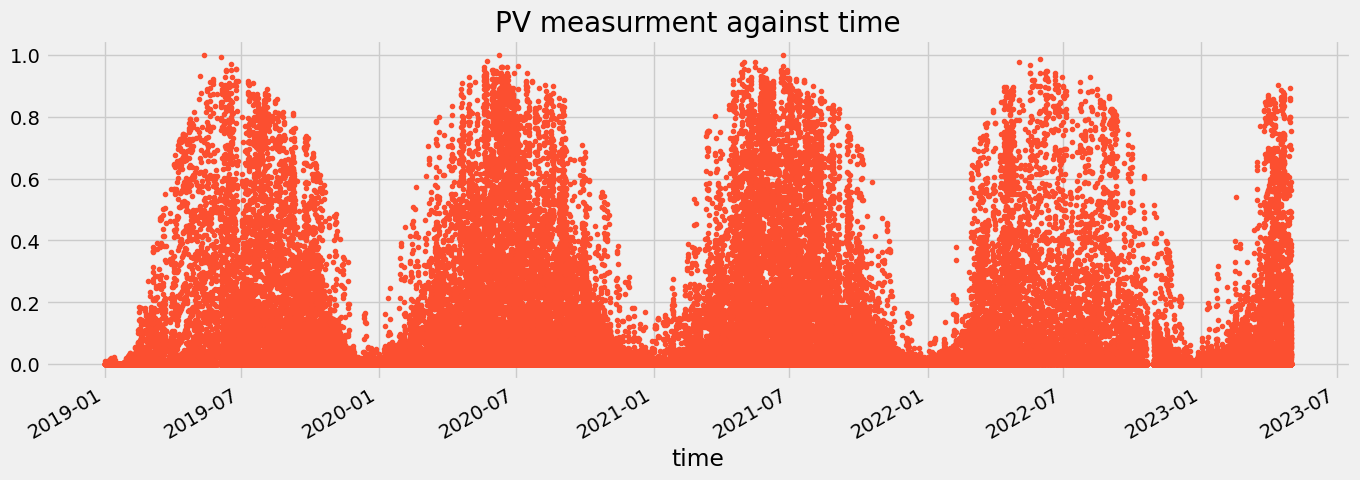

In [273]:
color_pal = sns.color_palette()

df["pv_measurement"].plot(style='.',
        figsize=(15, 5),
        color=color_pal[1],
        title='PV measurment against time')
plt.show()

### Preparing test data

- Excluding dates that should not be tested
- Including only the features we have defined

In [274]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

def prepare_test_data(x, location):
    x_test = x.copy()
    x_test.set_index('date_forecast', inplace = True)
    x_test.drop('date_calc', axis=1, inplace = True)

    x_test = x_test.resample('60min').mean()

    x_test = create_features(x_test)
    x_test['estimated'] = 1

    if location == 'A':
        x_test['location_A'], X_train_estimated_a['location_A'] = 1, 1
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0
    elif location == 'B':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 1, 1
        x_test['location_C'], X_train_estimated_a['location_C'] = 0, 0
    elif location == 'C':
        x_test['location_A'], X_train_estimated_a['location_A'] = 0, 0
        x_test['location_B'], X_train_estimated_a['location_B'] = 0, 0
        x_test['location_C'], X_train_estimated_a['location_C'] = 1, 1

    return x_test

In [275]:
x_test_a = prepare_test_data(X_test_estimated_a, 'A')
x_test_b = prepare_test_data(X_test_estimated_b, 'B')
x_test_c = prepare_test_data(X_test_estimated_c, 'C')

In [276]:
test_sub = pd.read_csv('../test.csv')
valid_dates = pd.to_datetime(test_sub['time'].unique())

In [277]:
x_test_a = x_test_a.loc[valid_dates]
x_test_b = x_test_a.loc[valid_dates]
x_test_c = x_test_a.loc[valid_dates]

In [278]:
X_test = pd.concat([x_test_a, x_test_b, x_test_c])
X_test = X_test[FEATURES]

### Disability Check

Check if the training data and the test data contains the same columns.

In [279]:
check_df = df.copy()
check_train = check_df[FEATURES]
if X_test.columns.equals(check_train.columns):
    print("EQUAL")
else:
    print("NOT EQUAL")
    print("DIFFERENCE\n", X_test.columns.difference(check_train.columns))

EQUAL


Check if test data has the right amount of rows.

In [280]:
if X_test.shape[0] != 2160:
    print("X_test has wrong amount of rows!")
    print("Shape =", X_test.shape[0])
else:
    print("GOOD")

GOOD


## Lets build the LSTM model

In [281]:
def series_to_supervised(data, target_column, n_in=1, n_out=1, dropnan=True):
    n_vars = data.shape[1] - 1  # minus 1 to account for target column
    dff = data.drop(columns=[target_column])
    target_df = data[target_column]
    
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('%s(t-%d)' % (col, i)) for col in dff.columns]
    
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        names += [('%s(t+%d)' % (col, i)) for col in dff.columns]
    
    # target sequence
    cols.append(target_df.shift(-n_out + 1))
    names.append(target_column)
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    
    return agg

# Example of how to use:
df_supervised = series_to_supervised(df, target_column='pv_measurement', n_in=3, n_out=1)


In [282]:
train_X, train_y = df[FEATURES], df[TARGET]
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))

train_X = train_X.astype('float32')
train_y = train_y.astype('float32')

In [283]:
train_X.shape

(92951, 1, 61)

In [284]:
train_X.shape[2]

61

In [285]:
train_y.shape

(92951,)

In [303]:
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(100, input_shape=(train_X.shape[0], train_X.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = build_lstm_model()

In [304]:
train_X = train_X.astype('float32')
train_y = train_y.astype('float32')

In [305]:
history = model.fit(train_X, train_y, epochs=100, batch_size=70, verbose=2)

Epoch 1/100


ValueError: in user code:

    File "/Users/simenstang/Documents/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/keras/src/engine/training.py", line 1377, in train_function  *
        return step_function(self, iterator)
    File "/Users/simenstang/Documents/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/keras/src/engine/training.py", line 1360, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/simenstang/Documents/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/keras/src/engine/training.py", line 1349, in run_step  **
        outputs = model.train_step(data)
    File "/Users/simenstang/Documents/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/keras/src/engine/training.py", line 1126, in train_step
        y_pred = self(x, training=True)
    File "/Users/simenstang/Documents/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/Users/simenstang/Documents/TDT4173/data/sigmoidwarriors/lib/python3.10/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_7" is incompatible with the layer: expected shape=(None, 92951, 61), found shape=(None, 1, 61)


In [289]:
X_test = X_test.astype('float32')

In [290]:
X_test = X_test.values.reshape((X_test.shape[0], 1, X_test.shape[1]))

In [291]:
predictions = model.predict(X_test)

68/68 [==============================] - 1s 3ms/step


In [292]:
predictions = pd.DataFrame(predictions, columns=['prediction'])

predictions.reset_index(drop=True, inplace=True)

predictions.head()

,prediction
0,-0.007062
1,-0.007062
2,-0.007062
3,0.019467
4,0.069990


In [293]:
loc_a = predictions.iloc[:len(predictions)//3]
loc_b = predictions.iloc[len(predictions)//3:2*len(predictions)//3]
loc_c = predictions.iloc[2*len(predictions)//3:]

In [294]:
n = len(predictions)

# De-normalizing

loc_a.loc[:, 'prediction'] = scaler_a.inverse_transform(loc_a['prediction'].values.reshape(-1, 1))
loc_b.loc[:, 'prediction'] = scaler_b.inverse_transform(loc_b['prediction'].values.reshape(-1, 1))
loc_c.loc[:, 'prediction'] = scaler_c.inverse_transform(loc_c['prediction'].values.reshape(-1, 1))

In [295]:
predictions = pd.concat([loc_a, loc_b, loc_c])

In [296]:
predictions.head(15)

,prediction
0,-40.488747
1,-40.488747
2,-40.488747
3,111.613060
4,401.279480
5,1762.920776
6,1762.920776
7,1762.920776
8,1762.920776
9,1762.920776


In [297]:
predictions.reset_index(inplace=True)
predictions.rename(columns={'index': 'id'}, inplace=True)
predictions.to_csv('predictions.csv', index=False)

In [298]:
predictions.loc[predictions['prediction'] < 0, 'prediction'] = 0
predictions.to_csv('predictions.csv', index=False)

In [55]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential, load_model
from scikeras.wrappers import KerasRegressor
#from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import numpy as np

def build_lstm_model(optimizer='adam', dropout=0.2, neurons=100):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model


# Assuming your dataset is split and reshaped into 3D [samples, timesteps, features]
train_X, train_y = df[FEATURES], df[TARGET]
train_X = train_X.values.reshape((train_X.shape[0], 1, train_X.shape[1]))

model = KerasRegressor(build_fn=build_lstm_model, epochs=20, batch_size=70, verbose=2)

parameters = {
    'epochs': [10, 20],
    'batch_size': [30, 70],
    'optimizer': ['adam'],
    'dropout': [0.2, 0.3],
    'neurons': [50, 100]
}


cv_split = TimeSeriesSplit(n_splits=5)
grid = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters, verbose=2)
grid_result = grid.fit(train_X, train_y)

# Store the best LSTM model
best_lstm_model = grid_result.best_estimator_.model

# Save the best LSTM model
best_lstm_model.save('best_lstm_model.h5')

# Predict using the best LSTM model
predictions = best_lstm_model.predict(X_test)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


ValueError: Invalid parameter dropout for estimator KerasRegressor.
This issue can likely be resolved by setting this parameter in the KerasRegressor constructor:
`KerasRegressor(dropout=0.2)`
Check the list of available parameters with `estimator.get_params().keys()`

### Saving the Model!

In [222]:
import joblib

joblib.dump(grid_search, 'xgboost_model_feature_engineering_1.pkl')

['xgboost_model_feature_engineering_1.pkl']

Redifing the training sets

In [299]:
train_a = pd.read_parquet('../A/train_targets.parquet')
train_b = pd.read_parquet('../B/train_targets.parquet')
train_c = pd.read_parquet('../C/train_targets.parquet')

train_a.set_index('time', inplace=True)
train_b.set_index('time', inplace=True)
train_c.set_index('time', inplace=True)

### Plotting A

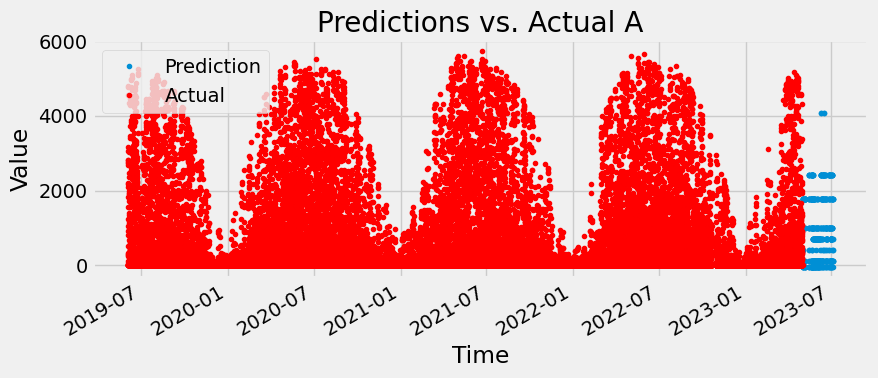

In [300]:
loc_a.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_a['prediction'].plot(style='.', label='Prediction')
train_a['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual A')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()


### Plotting B

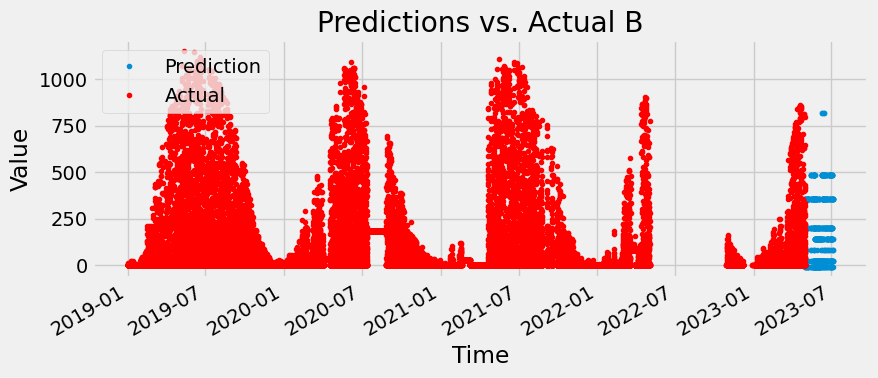

In [301]:
loc_b.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_b['prediction'].plot(style='.', label='Prediction')
train_b['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual B')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

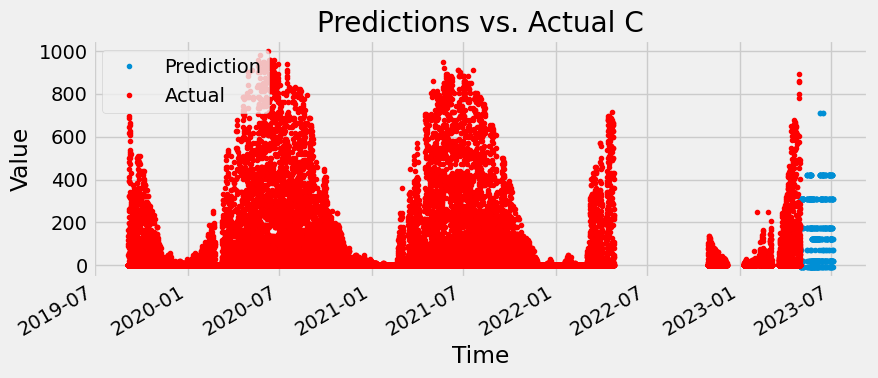

In [302]:
loc_c.set_index(valid_dates, inplace=True)

plt.figure(figsize=(9, 4))

loc_c['prediction'].plot(style='.', label='Prediction')
train_c['pv_measurement'].plot(style='.', label='Actual', color='red', linewidth=2)

plt.legend(loc='upper left')
plt.title('Predictions vs. Actual C')
plt.xlabel('Time')
plt.ylabel('Value')
plt.grid(True)
plt.tight_layout()
plt.show()

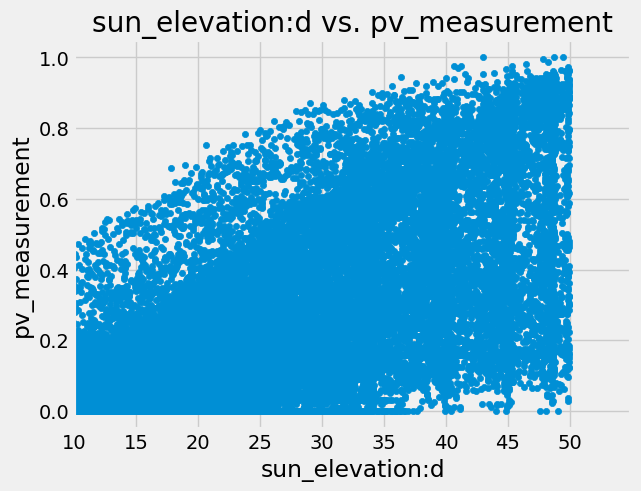

In [ ]:
df.plot(x='sun_elevation:d', y='pv_measurement', kind='scatter', xlim =(10,None))
plt.xlabel('sun_elevation:d')
plt.ylabel('pv_measurement')
plt.title('sun_elevation:d vs. pv_measurement')
plt.show()